# make plots
#### 9 Dec 2025

###  notes

In [2]:
import os
os.listdir()

['bp_detection_trends.png',
 'stagger',
 '.ipynb_checkpoints',
 'with_reps',
 'rr_accuracy_single_bp_wide.png',
 'null_all.csv',
 'sampling_density',
 'test_inf_all.csv',
 'median_rr_accuracy_facet_single_bp.png',
 'make_dfs.ipynb',
 'inf_all.csv',
 'trees_by_rho.png',
 'bp_detection_scatter.png',
 'median_rr_accuracy_facet_single.png',
 'make_plots.ipynb',
 'test_null_all.csv',
 'slurm-43266940.out',
 'make_plots-old.ipynb',
 'rr_accuracy_single.png',
 'vcf_stage',
 'run.sh',
 'description.txt']

### get started

#### import modules

In [3]:
import os

In [4]:
from tqdm.notebook import tqdm

In [5]:
import time
for i in tqdm(range(100)):
    time.sleep(0.05) # Simulate some work

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker

from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 

import itertools
from itertools import combinations

from Bio import SeqIO, AlignIO

import gzip
import csv

import subprocess, gzip, tempfile
import shutil

from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

# read in dfs

In [7]:
inf_all = pd.read_csv('inf_all.csv')
inf_all

,mu,pm,rr,rep,bin,r2,kind,n_trees_sim,n_trees_inf
0,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,inferred,1,3
1,1.000000e-10,0.001,1.000000e-13,0,2,0.915093,inferred,1,3
2,1.000000e-10,0.001,1.000000e-13,0,3,0.915093,inferred,1,3
3,1.000000e-10,0.001,1.000000e-13,0,4,0.915093,inferred,1,3
4,1.000000e-10,0.001,1.000000e-13,0,5,0.915093,inferred,1,3
...,...,...,...,...,...,...,...,...,...
690,1.000000e-07,3.000,3.000000e-07,0,25,0.376952,inferred,137234,9914
691,1.000000e-07,3.000,3.000000e-07,0,26,0.450914,inferred,137234,9914
692,1.000000e-07,3.000,3.000000e-07,0,27,0.388364,inferred,137234,9914
693,1.000000e-07,3.000,3.000000e-07,0,28,0.277969,inferred,137234,9914


In [8]:
null_all = pd.read_csv('null_all.csv')
null_all['kind'] = 'null'

#add n_trees vals to null df
to_merge = inf_all[['mu', 'rr', 'n_trees_sim', 'n_trees_inf']]
null_all = pd.merge(null_all, to_merge, on=['mu', 'rr'], how='left')

null_all

,mu,pm,rr,rep,bin,r2,kind,n_trees_sim,n_trees_inf
0,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,null,1,3
1,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,null,1,3
2,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,null,1,3
3,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,null,1,3
4,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,null,1,3
...,...,...,...,...,...,...,...,...,...
194380,1.000000e-07,3.000,3.000000e-07,0,29,0.120988,null,137234,9914
194381,1.000000e-07,3.000,3.000000e-07,0,29,0.120988,null,137234,9914
194382,1.000000e-07,3.000,3.000000e-07,0,29,0.120988,null,137234,9914
194383,1.000000e-07,3.000,3.000000e-07,0,29,0.120988,null,137234,9914


In [9]:
inf_all['pm'].unique()

array([1.e-03, 1.e-02, 1.e-01, 3.e-01, 1.e+00, 3.e+00])

# plotting

### additional x axis: expected number of breakpoints (num_trees - 1) ::: recombination rate

In [10]:
inf_all['breakpoints_sim'] = inf_all['n_trees_sim'] - 1
inf_all['breakpoints_inf'] = inf_all['n_trees_inf'] - 1

null_all['breakpoints_sim'] = null_all['n_trees_sim'] - 1
null_all['breakpoints_inf'] = null_all['n_trees_inf'] - 1

In [11]:
tree_counts = inf_all[['mu', 'pm', 'rr', 'breakpoints_sim', 'breakpoints_inf']]
tree_counts = tree_counts.groupby(['mu', 'rr']).agg(expected_breakpoints = ('breakpoints_sim', 'mean'))
tree_counts

expected_breakpoints
mu           rr                                
1.000000e-10 1.000000e-13                   0.0
             1.000000e-12                   1.0
             1.000000e-11                   8.0
             3.000000e-11                  13.0
             1.000000e-10                  49.0
             3.000000e-10                 150.0
1.000000e-09 1.000000e-12                   1.0
             1.000000e-11                   8.0
             1.000000e-10                  49.0
             3.000000e-10                 150.0
             1.000000e-09                 482.0
             3.000000e-09                1437.0
1.000000e-08 1.000000e-11                   8.0
             1.000000e-10                  49.0
             1.000000e-09                 482.0
             3.000000e-09                1437.0
             1.000000e-08                4664.0
             3.000000e-08               13991.0
1.000000e-07 1.000000e-10                  49.0
             1.000000e-09                 482.0
             1.000000e-08                4664.0
             3.000000e-08               13991.0
             1.000000e-07               46222.0
             3.000000e-07              137233.0

#### add breakpoints back to inf_all, null_all dfs

In [12]:
inf_all['avg_breakpoints'] = inf_all.groupby(['mu', 'rr'])['breakpoints_sim'].transform('mean')
null_all['avg_breakpoints'] = null_all.groupby(['mu', 'rr'])['breakpoints_sim'].transform('mean')

In [13]:
inf_all

,mu,pm,rr,rep,bin,r2,kind,n_trees_sim,n_trees_inf,breakpoints_sim,breakpoints_inf,avg_breakpoints
0,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,inferred,1,3,0,2,0.0
1,1.000000e-10,0.001,1.000000e-13,0,2,0.915093,inferred,1,3,0,2,0.0
2,1.000000e-10,0.001,1.000000e-13,0,3,0.915093,inferred,1,3,0,2,0.0
3,1.000000e-10,0.001,1.000000e-13,0,4,0.915093,inferred,1,3,0,2,0.0
4,1.000000e-10,0.001,1.000000e-13,0,5,0.915093,inferred,1,3,0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
690,1.000000e-07,3.000,3.000000e-07,0,25,0.376952,inferred,137234,9914,137233,9913,137233.0
691,1.000000e-07,3.000,3.000000e-07,0,26,0.450914,inferred,137234,9914,137233,9913,137233.0
692,1.000000e-07,3.000,3.000000e-07,0,27,0.388364,inferred,137234,9914,137233,9913,137233.0
693,1.000000e-07,3.000,3.000000e-07,0,28,0.277969,inferred,137234,9914,137233,9913,137233.0


In [14]:
# plot 
# x = recombination rate, 
# y = expected number of recombination breakpoints; also plot inferred number recombination breakpoints in dif color 

inf_all[['mu', 'pm', 'rr', 'breakpoints_sim', 'breakpoints_inf']].groupby(['pm', 'rr']).mean()

mu  breakpoints_sim  breakpoints_inf
pm    rr                                                          
0.001 1.000000e-13  1.000000e-10              0.0              2.0
      1.000000e-12  1.000000e-09              1.0              2.0
      1.000000e-11  1.000000e-08              8.0             19.0
      1.000000e-10  1.000000e-07             49.0            130.0
0.010 1.000000e-12  1.000000e-10              1.0              2.0
      1.000000e-11  1.000000e-09              8.0             15.0
      1.000000e-10  1.000000e-08             49.0             63.0
      1.000000e-09  1.000000e-07            482.0            625.0
0.100 1.000000e-11  1.000000e-10              8.0              4.0
      1.000000e-10  1.000000e-09             49.0             22.0
      1.000000e-09  1.000000e-08            482.0            285.0
      1.000000e-08  1.000000e-07           4664.0           2361.0
0.300 3.000000e-11  1.000000e-10             13.0              2.0
      3.000000e-10  1.000000e-09            150.0             46.0
      3.000000e-09  1.000000e-08           1437.0            443.0
      3.000000e-08  1.000000e-07          13991.0           4178.0
1.000 1.000000e-10  1.000000e-10             49.0              4.0
      1.000000e-09  1.000000e-09            482.0             82.0
      1.000000e-08  1.000000e-08           4664.0            687.0
      1.000000e-07  1.000000e-07          46222.0           7149.0
3.000 3.000000e-10  1.000000e-10            150.0             12.0
      3.000000e-09  1.000000e-09           1437.0            113.0
      3.000000e-08  1.000000e-08          13991.0            970.0
      3.000000e-07  1.000000e-07         137233.0           9913.0

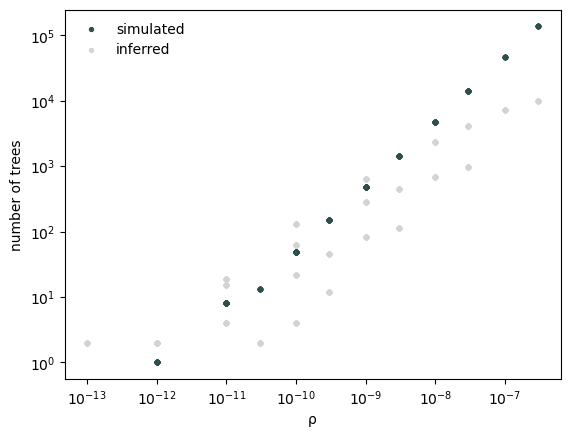

In [15]:
plt.figure()
plt.scatter(inf_all["rr"], inf_all["n_trees_sim"]-1, label="simulated", alpha = 1, c = 'darkslategrey', s = 8)
plt.scatter(inf_all["rr"], inf_all["n_trees_inf"]-1, label="inferred", alpha = 1, c = 'lightgrey', s =8)

plt.xlabel("ρ")
plt.ylabel("number of trees")


#plt.xlim(7e-14, 4e-8)
plt.xscale("log") 
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.yscale("log")
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())

#plt.ylim(-100, )

plt.legend(loc = 'upper left', frameon = False)
#plt.savefig("trees_by_rho.png") 
plt.show()


In [16]:
inf_all["mu"].unique()

array([1.e-10, 1.e-09, 1.e-08, 1.e-07])

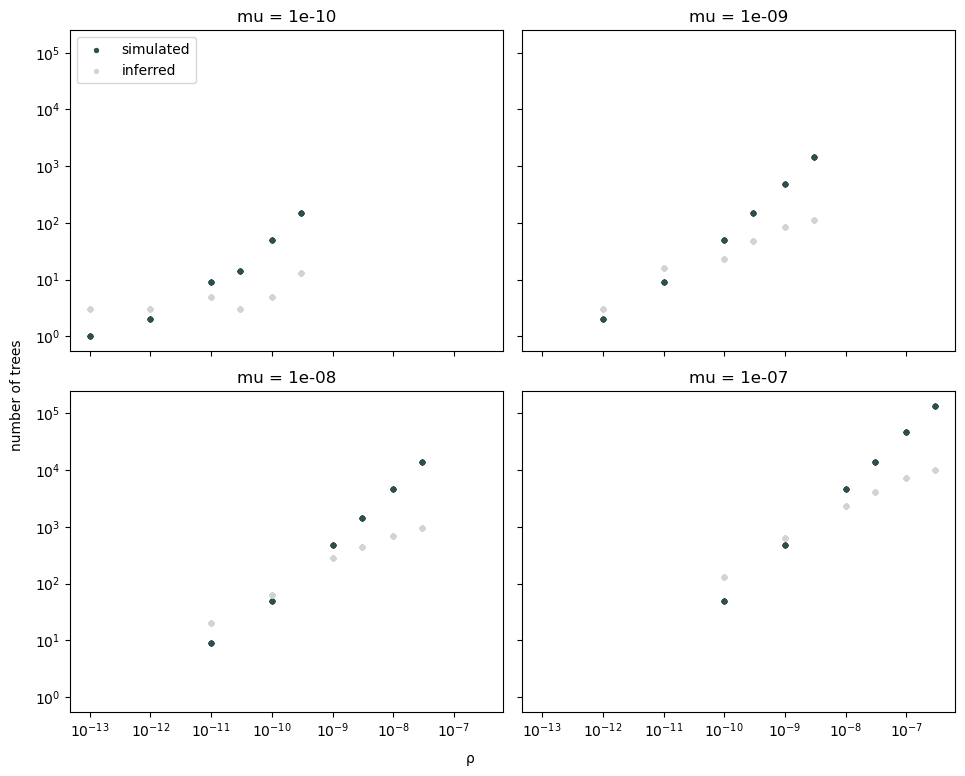

In [17]:
mus = sorted(inf_all["mu"].unique())

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, mu in zip(axes, mus):
    df_mu = inf_all[inf_all["mu"] == mu]

    ax.scatter(
        df_mu["rr"], df_mu["n_trees_sim"],
        alpha=1, c="darkslategrey", s=8, label="simulated"
    )
    ax.scatter(
        df_mu["rr"], df_mu["n_trees_inf"],
        alpha=1, c="lightgrey", s=8, label="inferred"
    )

    ax.set_xscale("log")
    plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
    plt.yscale("log")
    plt.gca().yaxis.set_minor_locator(ticker.NullLocator())
    #ax.set_xlim(7e-14, 4e-8)
    #ax.set_ylim(-100, 5000)
    ax.set_title(f"mu = {mu}")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "number of trees", va="center", rotation="vertical")

# single legend
axes[0].legend(loc="upper left")

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


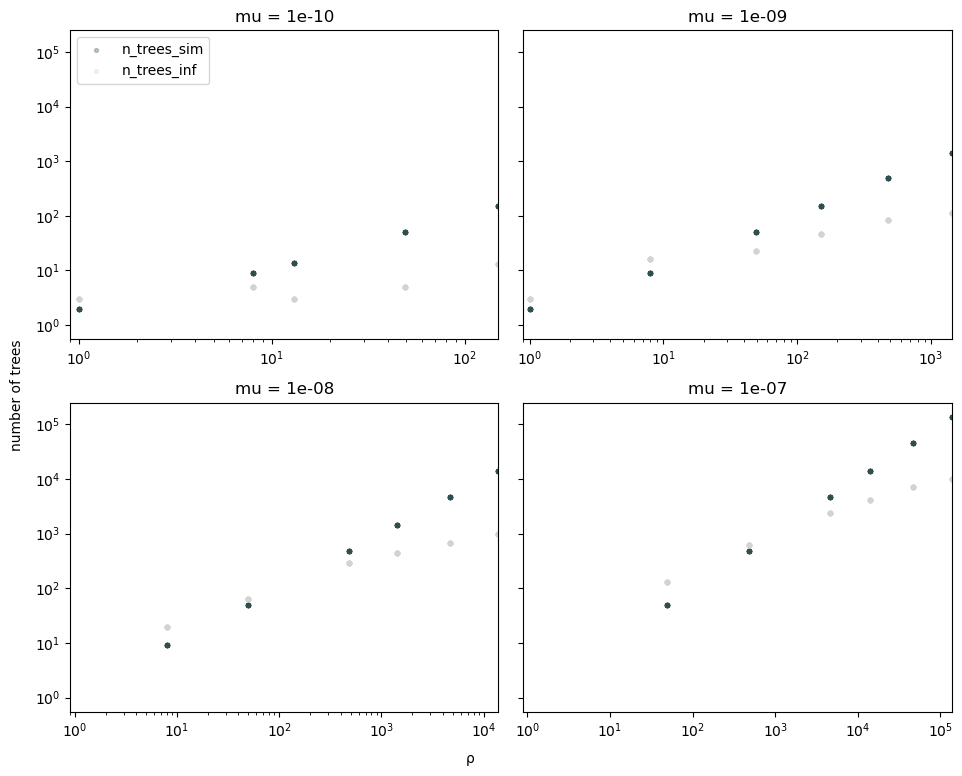

In [18]:
mus = sorted(inf_all["mu"].unique())

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)
axes = axes.flatten()

for ax, mu in zip(axes, mus):
    df_mu = inf_all[inf_all["mu"] == mu]

    ax.scatter(
        df_mu["avg_breakpoints"], df_mu["n_trees_sim"],
        alpha=0.3, c="darkslategrey", s=8, label="n_trees_sim"
    )
    ax.scatter(
        df_mu["avg_breakpoints"], df_mu["n_trees_inf"],
        alpha=0.3, c="lightgrey", s=8, label="n_trees_inf"
    )

    ax.set_xscale("log")
    plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
    plt.yscale("log")
    plt.gca().yaxis.set_minor_locator(ticker.NullLocator())
    ax.set_xlim(0.9, df_mu["avg_breakpoints"].max())
    #ax.set_ylim(-100, 5000)
    ax.set_title(f"mu = {mu}")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "number of trees", va="center", rotation="vertical")

# single legend
axes[0].legend(loc="upper left")

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


In [19]:
# rr_vals = tree_counts.index.get_level_values("rr").values
# bp_vals = tree_counts["expected_breakpoints"].values

### plot

In [20]:
null_s = null_all
inf_s = inf_all

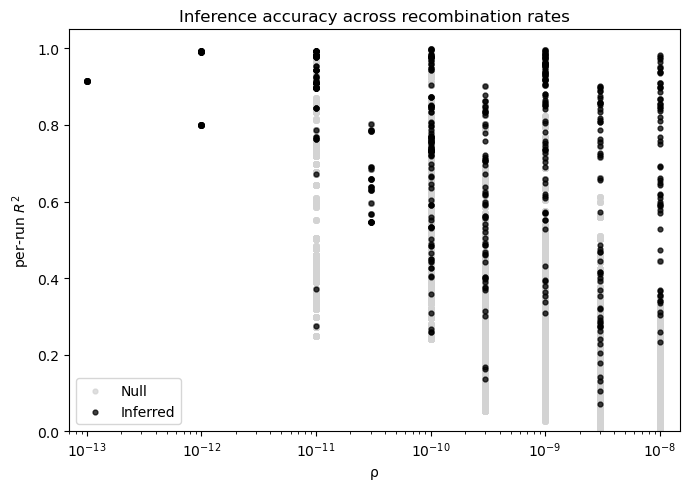

In [21]:
plt.figure(figsize=(7,5))

# plot nulls 
if len(null_all):
    plt.scatter(
        null_s["rr"], null_s["r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )

# plot inferred results colored by rr (or rr_hat)
if len(inf_all):
    sc = plt.scatter(
        inf_s["rr"], inf_s["r2"],
        #cmap=cmap,
        s=12, alpha=0.75, label="Inferred", c = 'black'
    )
    #plt.colorbar(sc, label="p/m")

plt.xlim(7e-14, 1.5e-8)
plt.xscale("log") 
plt.ylim(0,1.05)

#axis w/ expected breakpoints
rr_vals = tree_counts.index.get_level_values("rr").values
bp_vals = tree_counts["expected_breakpoints"].values

plt.xlabel("ρ")
plt.ylabel("per-run $R^2$")
plt.title("Inference accuracy across recombination rates")
plt.legend(frameon=True, loc="lower left")
plt.tight_layout()

#plt.savefig("mu_scatter_2.png") 
plt.show()

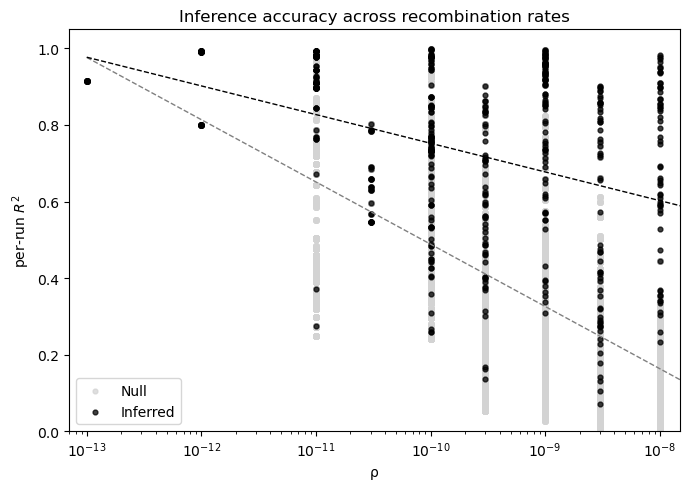

In [22]:
plt.figure(figsize=(7,5))

# plot nulls 
if len(null_all):
    plt.scatter(
        null_s["rr"], null_s["r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )
    m, b = np.polyfit(np.log(null_s["rr"]), null_s["r2"], 1)
    log_x_regression = np.linspace(min(np.log(null_s["rr"])), max(np.log(null_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='grey', linestyle='--', lw = 1)

# plot inferred results colored by rr (or rr_hat)
if len(inf_all):
    sc = plt.scatter(
        inf_s["rr"], inf_s["r2"],
        #cmap=cmap,
        s=12, alpha=0.75, label="Inferred", c = 'black'
    )
    m, b = np.polyfit(np.log(inf_s["rr"]), inf_s["r2"], 1)
    log_x_regression = np.linspace(min(np.log(inf_s["rr"])), max(np.log(inf_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='black', linestyle='--', lw = 1)
    #plt.colorbar(sc, label="p/m")

plt.xlim(7e-14, 1.5e-8)
plt.xscale("log") 
plt.ylim(0,1.05)
plt.xlabel("ρ")
plt.ylabel("per-run $R^2$")
plt.title("Inference accuracy across recombination rates")
plt.legend(frameon=True, loc="lower left")
plt.tight_layout()
#plt.savefig("mu_scatter_2.png") 
plt.show()

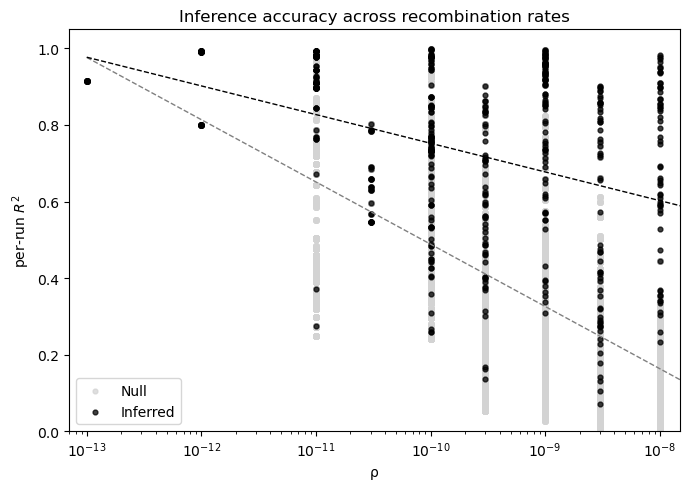

In [23]:
plt.figure(figsize=(7,5))

# plot nulls 
if len(null_all):
    plt.scatter(
        null_s["rr"], null_s["r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )
    m, b = np.polyfit(np.log(null_s["rr"]), null_s["r2"], 1)
    log_x_regression = np.linspace(min(np.log(null_s["rr"])), max(np.log(null_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='grey', linestyle='--', lw = 1)

# plot inf colored by rr
if len(inf_all):
    sc = plt.scatter(
        inf_s["rr"], inf_s["r2"],
        #cmap=cmap,
        s=12, alpha=0.75, label="Inferred", c = 'black'
    )
    m, b = np.polyfit(np.log(inf_s["rr"]), inf_s["r2"], 1)
    log_x_regression = np.linspace(min(np.log(inf_s["rr"])), max(np.log(inf_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='black', linestyle='--', lw = 1)
    #plt.colorbar(sc, label="p/m")

plt.xlim(7e-14, 1.5e-8)
plt.xscale("log") 
plt.ylim(0,1.05)
plt.xlabel("ρ")
plt.ylabel("per-run $R^2$")
plt.title("Inference accuracy across recombination rates")
plt.legend(frameon=True, loc="lower left")
plt.tight_layout()
#plt.savefig("mu_scatter_2.png") 
plt.show()

## plot medians

In [24]:
inf_s

,mu,pm,rr,rep,bin,r2,kind,n_trees_sim,n_trees_inf,breakpoints_sim,breakpoints_inf,avg_breakpoints
0,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,inferred,1,3,0,2,0.0
1,1.000000e-10,0.001,1.000000e-13,0,2,0.915093,inferred,1,3,0,2,0.0
2,1.000000e-10,0.001,1.000000e-13,0,3,0.915093,inferred,1,3,0,2,0.0
3,1.000000e-10,0.001,1.000000e-13,0,4,0.915093,inferred,1,3,0,2,0.0
4,1.000000e-10,0.001,1.000000e-13,0,5,0.915093,inferred,1,3,0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
690,1.000000e-07,3.000,3.000000e-07,0,25,0.376952,inferred,137234,9914,137233,9913,137233.0
691,1.000000e-07,3.000,3.000000e-07,0,26,0.450914,inferred,137234,9914,137233,9913,137233.0
692,1.000000e-07,3.000,3.000000e-07,0,27,0.388364,inferred,137234,9914,137233,9913,137233.0
693,1.000000e-07,3.000,3.000000e-07,0,28,0.277969,inferred,137234,9914,137233,9913,137233.0


In [25]:
# metric (mean, median) per-REP! 5 medians per p-m  

inf_s['median_r2'] = inf_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('median')
inf_s['mean_r2'] = inf_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('mean')
null_s['median_r2'] = null_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('median')
null_s['mean_r2'] = null_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('mean')

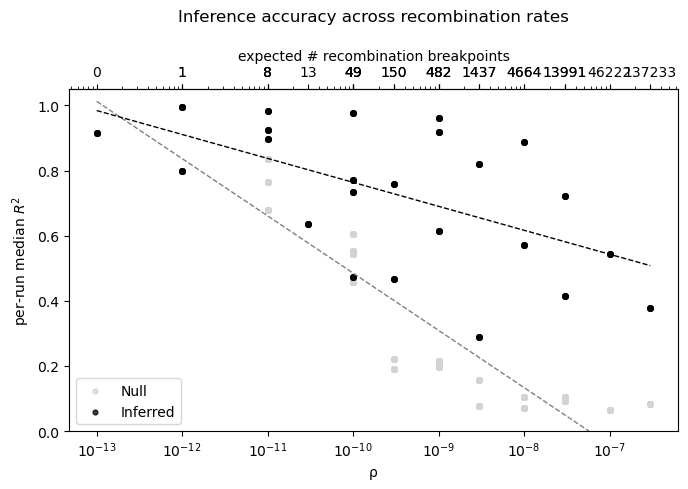

In [26]:
fig, ax = plt.subplots(figsize=(7,5))

# plot nulls 
if len(null_all):
    ax.scatter(
        null_s["rr"], null_s["median_r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )
    m, b = np.polyfit(np.log(null_s["rr"]), null_s["median_r2"], 1)
    log_x_regression = np.linspace(min(np.log(null_s["rr"])), max(np.log(null_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='grey', linestyle='--', lw = 1)

# plot inferred results
if len(inf_all):
    ax.scatter(
        inf_s["rr"], inf_s["median_r2"],
        s=12, alpha=0.75, label="Inferred", c='black'
    )
    m, b = np.polyfit(np.log(inf_s["rr"]), inf_s["median_r2"], 1)
    log_x_regression = np.linspace(min(np.log(inf_s["rr"])), max(np.log(inf_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='black', linestyle='--', lw = 1)

# main x axis settings
ax.set_xscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
#ax.set_xlim(7e-14, 1.5e-8)
ax.set_ylim(0, 1.05)

# secondary x axis w/ expected breakpoints -----
rr_vals = tree_counts.index.get_level_values("rr").values
bp_vals = tree_counts["expected_breakpoints"].values

secax = ax.secondary_xaxis("top")
secax.set_xticks(rr_vals)
secax.set_xticklabels([f"{bp:.0f}" for bp in bp_vals])
secax.set_xlabel("expected # recombination breakpoints")

# labels / title / legend
ax.set_xlabel("ρ")
ax.set_ylabel("per-run median $R^2$")
ax.set_title("Inference accuracy across recombination rates", fontsize=12, pad=20)
ax.legend(frameon=True, loc="lower left")

fig.tight_layout()
plt.show()

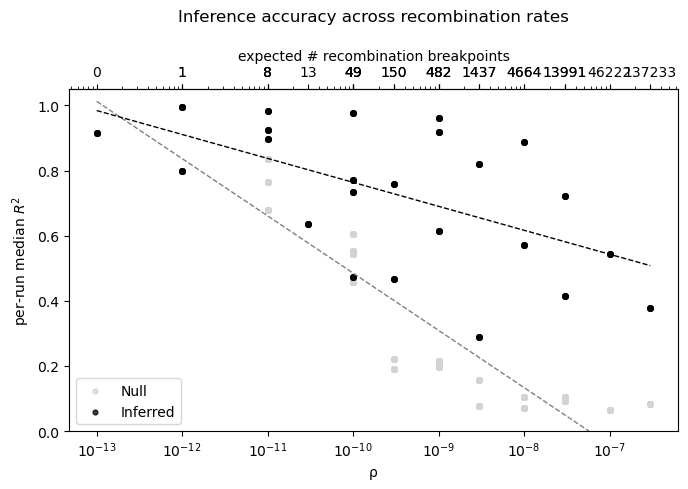

In [27]:
fig, ax = plt.subplots(figsize=(7,5))

# plot nulls 
if len(null_all):
    ax.scatter(
        null_s["rr"], null_s["median_r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )
    m, b = np.polyfit(np.log(null_s["rr"]), null_s["median_r2"], 1)
    log_x_regression = np.linspace(min(np.log(null_s["rr"])), max(np.log(null_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='grey', linestyle='--', lw = 1)

# plot inferred results
if len(inf_all):
    ax.scatter(
        inf_s["rr"], inf_s["median_r2"],
        s=12, alpha=0.75, label="Inferred", c='black'
    )
    m, b = np.polyfit(np.log(inf_s["rr"]), inf_s["median_r2"], 1)
    log_x_regression = np.linspace(min(np.log(inf_s["rr"])), max(np.log(inf_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='black', linestyle='--', lw = 1)

# main x axis settings
ax.set_xscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
#ax.set_xlim(7e-14, 1.5e-8)
ax.set_ylim(0, 1.05)

# secondary x axis w/ expected breakpoints -----
rr_vals = tree_counts.index.get_level_values("rr").values
bp_vals = tree_counts["expected_breakpoints"].values

secax = ax.secondary_xaxis("top")
secax.set_xticks(rr_vals)
secax.set_xticklabels([f"{bp:.0f}" for bp in bp_vals])
secax.set_xlabel("expected # recombination breakpoints")

# labels / title / legend
ax.set_xlabel("ρ")
ax.set_ylabel("per-run median $R^2$")
ax.set_title("Inference accuracy across recombination rates", fontsize=12, pad=20)
ax.legend(frameon=True, loc="lower left")

fig.tight_layout()
plt.show()

### plotting expected # breakpoints vs detectable # breakpoints (by mutation rate)

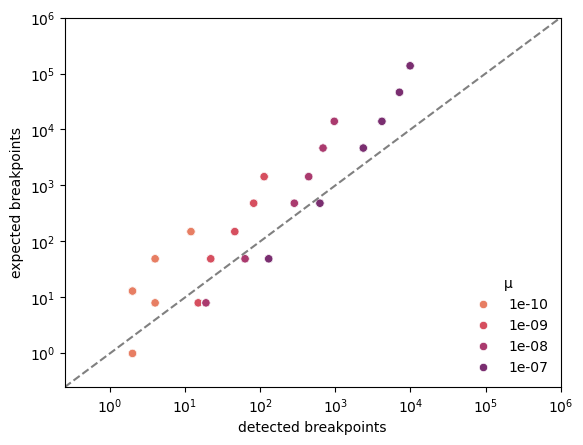

In [28]:
# y axis: expected number --  breakpoints_sim
# x axis: detectable number (color by mu) breakpoints_inf 

# bkpts = inf_all[


# plt.figure()
# plt.scatter(inf_all["breakpoints_sim"], inf_all["breakpoints_inf"], alpha = 0.5, c = 'darkslategrey', s = 8)
# plt.scatter(inf_all["rr"], inf_all["n_trees_inf"]-1, label="n_trees_inf", alpha = 0.5, c = 'lightgrey', s =8)

# plt.xlabel("ρ")
# plt.ylabel("number of trees")


# #plt.xlim(7e-14, 4e-8)
# plt.xscale("log") 
# plt.yscale("log")

# #plt.ylim(-100, )

# plt.legend(loc = 'upper left')
# plt.savefig("trees_by_rho.png") 
# plt.show()

bp_colors = sns.color_palette("flare", 4)

sns.scatterplot(data=inf_all, x='breakpoints_inf', y='breakpoints_sim', hue='mu', palette=bp_colors)
plt.axline([0, 0], slope=1, color='grey', linestyle='--')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())
plt.xscale('log')
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.xlim(0.250, 10e5)
plt.ylim(0.250, 10e5)
plt.ylabel("expected breakpoints")
plt.xlabel("detected breakpoints")
plt.legend(title="μ", loc = 'lower right', frameon = False)
#plt.savefig("bp_detection_scatter.png")

plt.show()




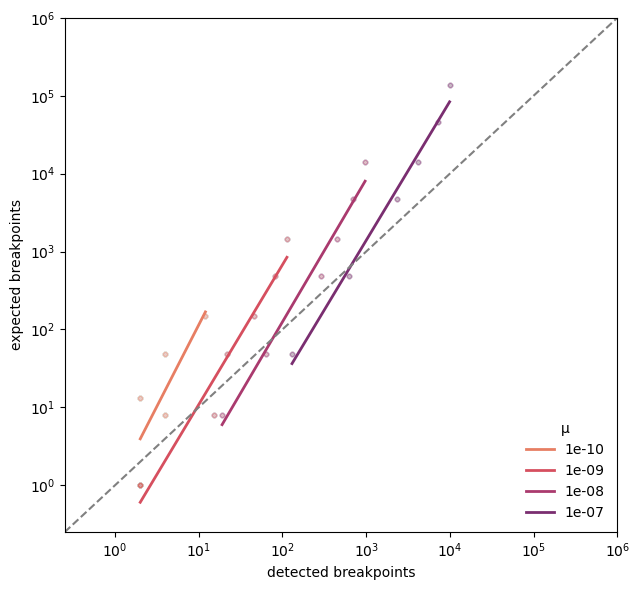

In [29]:
df = inf_all.copy()

mu_values = sorted(df["mu"].unique())

bp_colors = sns.color_palette("flare", len(mu_values))

plt.figure(figsize=(6.5, 6))

# points + trend lines by mu 
for mu, color in zip(mu_values, bp_colors):
    sub = df[df["mu"] == mu]
    if len(sub) == 0:
        continue

    # points (low alpha)
    plt.scatter(
        sub["breakpoints_inf"],
        sub["breakpoints_sim"],
        s=12,
        alpha=0.01,
        color=color
    )

    # trend line 
    if len(sub) >= 2:
        # only pos values for log scale 
        sub_fit = sub[(sub["breakpoints_inf"] > 0) & (sub["breakpoints_sim"] > 0)]
        if len(sub_fit) >= 2:
            lx = np.log10(sub_fit["breakpoints_inf"].to_numpy())
            ly = np.log10(sub_fit["breakpoints_sim"].to_numpy())
    
            m, b = np.polyfit(lx, ly, 1)
    
            xline = np.logspace(lx.min(), lx.max(), 200)
            yline = 10 ** (m * np.log10(xline) + b)
    
            plt.plot(xline, yline, lw=2, color=color, label=f"{mu:g}")

# y = x
plt.axline([1, 1], slope=1, color="grey", linestyle="--")

# fmt
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())

plt.xlim(0.250, 1e6)
plt.ylim(0.250, 1e6)

plt.xlabel("detected breakpoints")
plt.ylabel("expected breakpoints", )
plt.legend(title="μ", loc = 'lower right', frameon = False)
plt.tight_layout()
#plt.savefig("bp_detection_trends.png")
plt.show()


In [30]:
inf_all['rr'].unique()

array([1.e-13, 1.e-12, 1.e-12, 1.e-11, 3.e-11, 1.e-10, 1.e-10, 3.e-10,
       1.e-09, 3.e-09, 1.e-08, 3.e-08, 3.e-08, 1.e-07, 3.e-07])

### color by pm

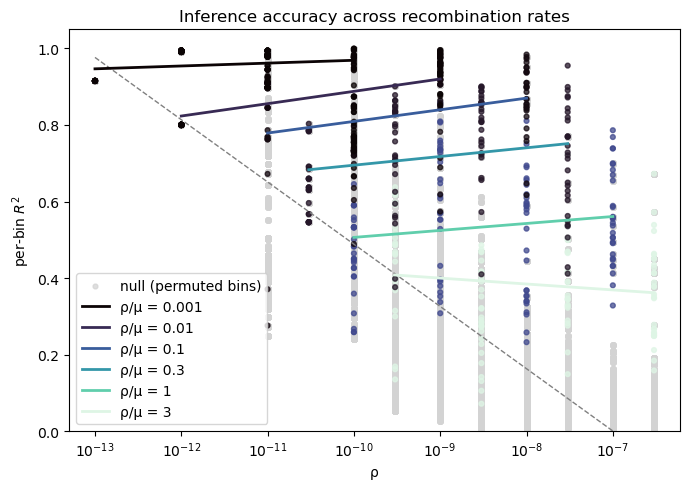

In [33]:
plt.figure(figsize=(7,5))

# colormap for different pm values 
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

# null pts
if len(null_all):
    plt.scatter(
        null_s["rr"], null_s["r2"],
        s=12, alpha=0.75, c="lightgrey", label="null (permuted bins)"
    )
    m, b = np.polyfit(np.log(null_s["rr"]), null_s["r2"], 1)
    log_x = np.linspace(min(np.log(null_s["rr"])), max(np.log(null_s["rr"])), 100)
    plt.plot(np.exp(log_x), m * log_x + b, color="grey", linestyle="--", lw=1)

# inf pts (colored by pm) 
if len(inf_all):
    sc = plt.scatter(
        inf_s["rr"],
        inf_s["r2"],
        c=inf_s["pm"],
        cmap=cmap,
        s=12,
        alpha=0.75
    )
    #cbar = plt.colorbar(sc, label="p/m")

    # regression lines per pm
    for pm, color in zip(pm_values, colors):
        subset = inf_s[inf_s["pm"] == pm]
        if len(subset) < 2:
            continue

        m, b = np.polyfit(np.log(subset["rr"]), subset["r2"], 1)
        log_x = np.linspace(
            min(np.log(subset["rr"])),
            max(np.log(subset["rr"])),
            200
        )
        y = m * log_x + b

        plt.plot(
            np.exp(log_x), y,
            color=color,
            lw=2,
            label=f"ρ/μ = {pm:g}"
        )


# axes / labels
plt.xscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
#plt.xlim(7e-14, 1.5e-8)
plt.xlim(inf_s["rr"].min() - inf_s["rr"].min()*0.5 , inf_s["rr"].max() + inf_s["rr"].max()*1)



plt.ylim(0, 1.05)
plt.xlabel("ρ")
plt.ylabel("per-bin $R^2$")
plt.title("Inference accuracy across recombination rates")
plt.legend(frameon=True, loc="lower left")
plt.tight_layout()
#plt.savefig("rr_accuracy.png")
plt.show()



### facet

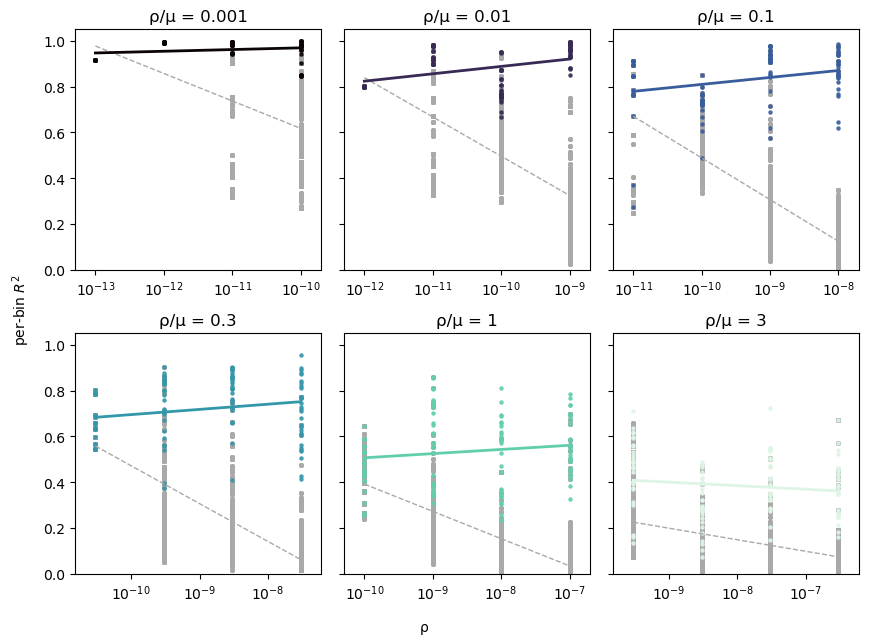

In [34]:
# colormap for different pm values 
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

xlims = [(7e-14, 5e-6)] * len(pm_values)

fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharex=False, sharey=True)

for ax, pm, color, xlim in zip(axes.flatten(), pm_values, colors, xlims):

    # subset by pm (inf)
    inf_sub = inf_s[inf_s["pm"] == pm]

    # subset by pm (null)
    null_sub = null_s[null_s["pm"] == pm] 

    # plot null
    if len(null_sub):
        ax.scatter(
            null_sub["rr"], null_sub["r2"],
            s=5, alpha=0.75, color="darkgrey", label="null"
        )
        if len(null_sub) >= 2:
            m_null, b_null = np.polyfit(np.log(null_sub["rr"]), null_sub["r2"], 1)
            log_x_null = np.linspace(np.log(null_sub["rr"]).min(),
                                     np.log(null_sub["rr"]).max(), 200)
            ax.plot(np.exp(log_x_null),
                    m_null * log_x_null + b_null,
                    color="darkgrey", linestyle="--", lw=1)

    # plot inf
    if len(inf_sub):
        ax.scatter(
            inf_sub["rr"], inf_sub["r2"],
            s=5, alpha=0.85, color=color, label="inferred"
        )
        if len(inf_sub) >= 2:
            m_inf, b_inf = np.polyfit(np.log(inf_sub["rr"]), inf_sub["r2"], 1)
            log_x_inf = np.linspace(np.log(inf_sub["rr"]).min(),
                                    np.log(inf_sub["rr"]).max(), 200)
            ax.plot(np.exp(log_x_inf),
                    m_inf * log_x_inf + b_inf,
                    color=color, lw=2, label="fit")

        # x-lims for log scale 
        xmin = inf_sub["rr"].min()
        xmax = inf_sub["rr"].max()
        ax.set_xlim(xmin * 0.5, xmax * 2.0)

    else:
        ax.set_xlim(xlim)

    # fmt
    ax.set_xscale("log")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.set_ylim(0, 1.05)
    ax.set_title(f"ρ/μ = {pm:g}")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "per-bin $R^2$", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])

#plt.savefig("rr_accuracy_facet.png")

plt.show()


## medians r2 per-rep

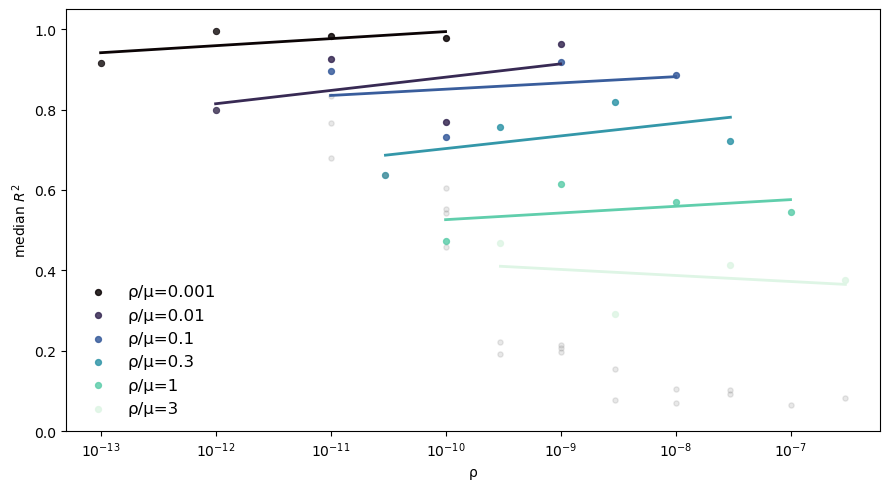

In [35]:
fig, ax = plt.subplots(figsize=(9, 5))

# colormap for different pm values
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

# aggregate so theres 1 row per (pm, rr) combo
inf_fit = (inf_s.groupby(["pm", "rr"], as_index=False).agg(median_r2=("median_r2", "median")))

null_fit = (null_s.groupby(["pm", "rr"], as_index=False).agg(median_r2=("median_r2", "median")))

# plot per pm 
for pm, color in zip(pm_values, colors):
    # inferred
    sub_i = inf_fit[np.isclose(inf_fit["pm"], pm)]
    if len(sub_i):
        ax.scatter(
            sub_i["rr"], sub_i["median_r2"],
            s=18, alpha=0.85, color=color,
            label=f"ρ/μ={pm:g}"
        )
        if len(sub_i) >= 2:
            lx = np.log(sub_i["rr"].to_numpy())
            y = sub_i["median_r2"].to_numpy()
            m, b = np.polyfit(lx, y, 1)
            log_x = np.linspace(lx.min(), lx.max(), 200)
            ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=2)

    # null (same color, lower alpha)
    sub_n = null_fit[np.isclose(null_fit["pm"], pm)]
    if len(sub_n):
        ax.scatter(
            sub_n["rr"], sub_n["median_r2"],
            s=14, alpha=0.18, color='grey'#,
           # label=f"null ρ/μ={pm:g}"
        )

    # if len(null_all):
    #     ax.scatter(
    #         null_s["rr"], null_s["median_r2"],
    #         s=12, alpha=0.75, c="lightgrey", label="null (permuted bins)"
    #     )
        # if len(sub_n) >= 2:
        #     lx = np.log(sub_n["rr"].to_numpy())
        #     y = sub_n["median_r2"].to_numpy()
        #     m, b = np.polyfit(lx, y, 1)
        #     log_x = np.linspace(lx.min(), lx.max(), 200)
        #     ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=1, ls="--", alpha=0.35)

# fmt axes
ax.set_xscale("log")
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.set_ylim(0, 1.05)

# x limits from inferred, else use null
all_rr = inf_fit["rr"] if len(inf_fit) else null_fit["rr"]
ax.set_xlim(all_rr.min() * 0.5, all_rr.max() * 2.0)

ax.set_xlabel("ρ")
ax.set_ylabel("median $R^2$")


ax.legend(frameon=False, fontsize=12, loc="lower left", ncol=1)

fig.tight_layout()
#plt.savefig("rr_accuracy_single_bp_wide.png")
plt.show()


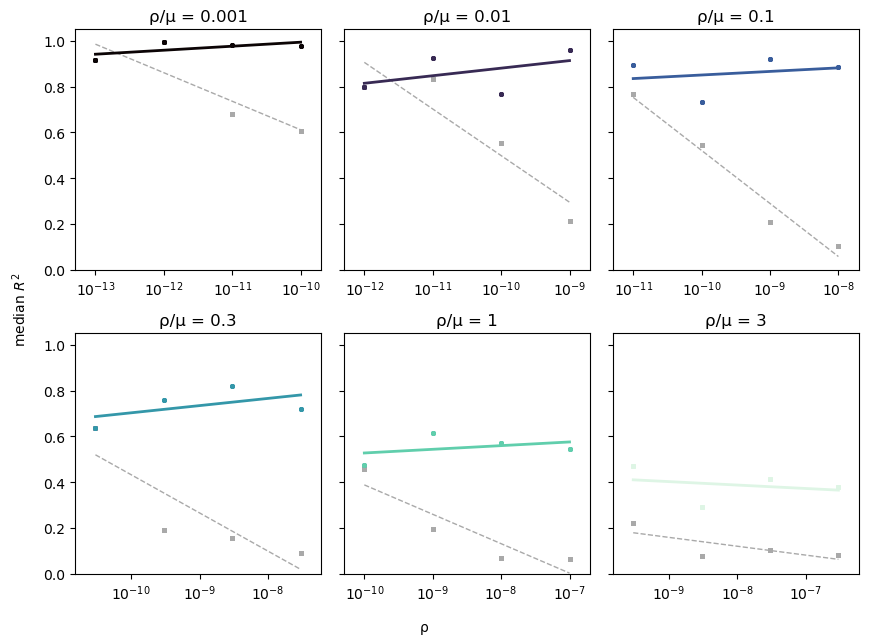

In [36]:
xlims = [(7e-14, 5e-6)] * len(pm_values)

fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharex=False, sharey=True)

for ax, pm, color, xlim in zip(axes.flatten(), pm_values, colors, xlims):

    # subset by category (inf/null) 
    inf_sub = inf_s[inf_s["pm"] == pm]
    null_sub = null_s[null_s["pm"] == pm]

    # plot null
    if len(null_sub):
        ax.scatter(
            null_sub["rr"], null_sub["median_r2"],
            s=5, alpha=0.75, color="darkgrey", label="null"
        )
        if len(null_sub) >= 2:
            m_null, b_null = np.polyfit(np.log(null_sub["rr"]), null_sub["median_r2"], 1)
            log_x_null = np.linspace(
                np.log(null_sub["rr"]).min(),
                np.log(null_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_null),
                m_null * log_x_null + b_null,
                color="darkgrey", linestyle="--", lw=1
            )

    # plot inf
    if len(inf_sub):
        ax.scatter(
            inf_sub["rr"], inf_sub["median_r2"],
            s=5, alpha=0.85, color=color, label="inferred"
        )
        if len(inf_sub) >= 2:
            m_inf, b_inf = np.polyfit(np.log(inf_sub["rr"]), inf_sub["median_r2"], 1)
            log_x_inf = np.linspace(
                np.log(inf_sub["rr"]).min(),
                np.log(inf_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_inf),
                m_inf * log_x_inf + b_inf,
                color=color, lw=2, label="fit"
            )

        # x lims
        xmin = inf_sub["rr"].min()
        xmax = inf_sub["rr"].max()
        ax.set_xlim(xmin * 0.5, xmax * 2.0)

    else:
        ax.set_xlim(xlim)

    # fmt
    ax.set_xscale("log")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.set_ylim(0, 1.05)
    ax.set_title(f"ρ/μ = {pm:g}")
    # ax.legend(frameon=True, fontsize=8, loc="lower left")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "median $R^2$", va="center", rotation="vertical")
#fig.text(0.5, 1.0, "single rep")


plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])

#plt.savefig("median_rr_accuracy_facet_single.png")
plt.show()


#### trying to shift x axis to num_expected_bps

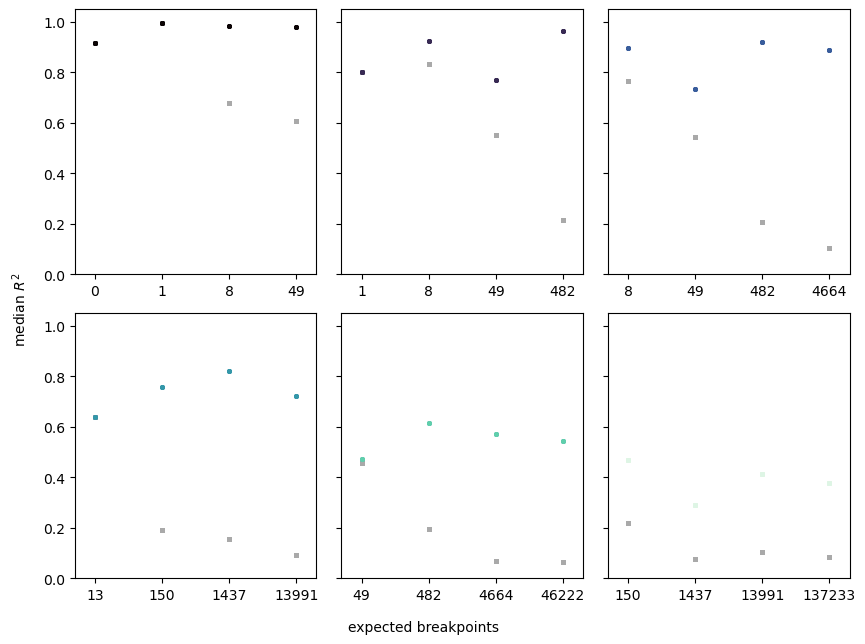

In [40]:
xlims = [(7e-14, 5e-6)] * len(pm_values)

fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharex=False, sharey=True)

for ax, pm, color, xlim in zip(axes.flatten(), pm_values, colors, xlims):

    # subset
    inf_sub = inf_s[inf_s["pm"] == pm].copy()
    null_sub = null_s[null_s["pm"] == pm].copy()

    # discrete mapping b/w rr and avg_breakpoints 
    bp_map = (
        inf_sub[["rr", "avg_breakpoints"]]
        .dropna()
        .drop_duplicates(subset=["rr"])
        .sort_values("rr")
    )
    rr_ticks = bp_map["rr"].to_numpy()
    bp_labels = bp_map["avg_breakpoints"].to_numpy()

    # null points
    if len(null_sub):
        ax.scatter(
            null_sub["rr"], null_sub["median_r2"],
            s=5, alpha=0.75, color="darkgrey", label="null"
        )

    # inf points 
    
    if len(inf_sub):
        ax.scatter(
            inf_sub["rr"], inf_sub["median_r2"],
            s=5, alpha=0.85, color=color, label="inferred"
        )

        # x lims based on inferred rr range
        xmin = inf_sub["rr"].min()
        xmax = inf_sub["rr"].max()
        ax.set_xlim(xmin * 0.5, xmax * 2.0)
    else:
        ax.set_xlim(xlim)

    # x axis showing just discrete breakpoints 
    ax.set_xscale("log")
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    if len(rr_ticks):
        max_labels = 5  # tweak for clutter
        if len(rr_ticks) > max_labels:
            keep = np.linspace(0, len(rr_ticks) - 1, max_labels, dtype=int)
            rr_ticks_show = rr_ticks[keep]
            bp_labels_show = bp_labels[keep]
        else:
            rr_ticks_show = rr_ticks
            bp_labels_show = bp_labels

        ax.set_xticks(rr_ticks_show)
        ax.set_xticklabels([f"{b:g}" for b in bp_labels_show])

    # y fmt
    ax.set_ylim(0, 1.05)

# shared labels
fig.text(0.5, 0.04, "expected breakpoints", ha="center")
fig.text(0.04, 0.5, "median $R^2$", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])
# plt.savefig("median_rr_accuracy_facet_discrete_bp.png", dpi=300)
plt.show()


## means r2 per-rep

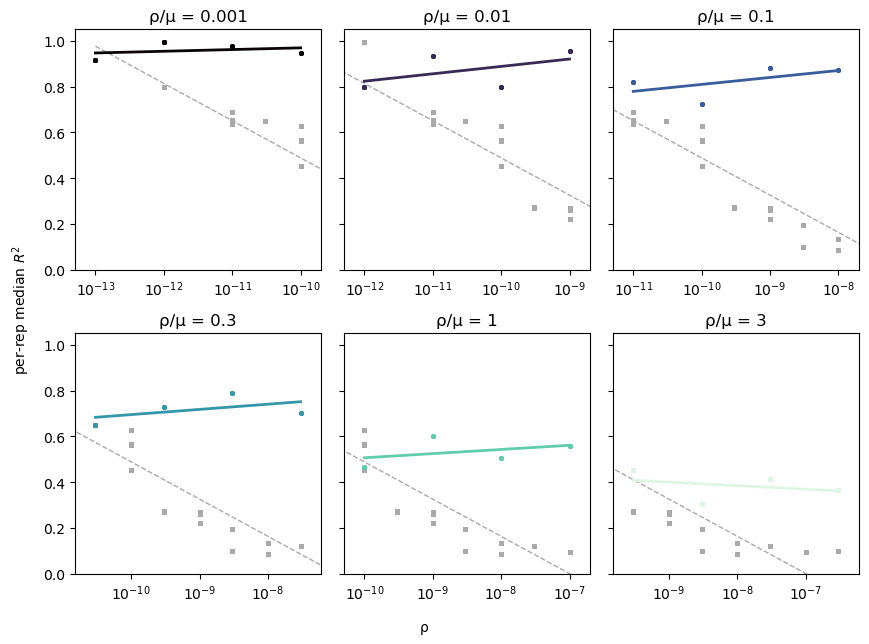

In [40]:
xlims = [(7e-14, 5e-6)] * len(pm_values)

fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharex=False, sharey=True)

for ax, pm, color, xlim in zip(axes.flatten(), pm_values, colors, xlims):

    # subset by category (inf/null) 
    inf_sub = inf_s[inf_s["pm"] == pm]
    null_s[null_s["pm"] == pm]

    # plot null
    if len(null_sub):
        ax.scatter(
            null_sub["rr"], null_sub["mean_r2"],
            s=5, alpha=0.75, color="darkgrey", label="null"
        )
        if len(null_sub) >= 2:
            m_null, b_null = np.polyfit(np.log(null_sub["rr"]), null_sub["mean_r2"], 1)
            log_x_null = np.linspace(
                np.log(null_sub["rr"]).min(),
                np.log(null_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_null),
                m_null * log_x_null + b_null,
                color="darkgrey", linestyle="--", lw=1
            )

    # plot inf
    if len(inf_sub):
        ax.scatter(
            inf_sub["rr"], inf_sub["mean_r2"],
            s=5, alpha=0.85, color=color, label="inferred"
        )
        if len(inf_sub) >= 2:
            m_inf, b_inf = np.polyfit(np.log(inf_sub["rr"]), inf_sub["mean_r2"], 1)
            log_x_inf = np.linspace(
                np.log(inf_sub["rr"]).min(),
                np.log(inf_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_inf),
                m_inf * log_x_inf + b_inf,
                color=color, lw=2, label="fit"
            )

        # x lims
        xmin = inf_sub["rr"].min()
        xmax = inf_sub["rr"].max()
        ax.set_xlim(xmin * 0.5, xmax * 2.0)

    else:
        ax.set_xlim(xlim)

    # fmt
    ax.set_xscale("log")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.set_ylim(0, 1.05)
    ax.set_title(f"ρ/μ = {pm:g}")
    # ax.legend(frameon=True, fontsize=8, loc="lower left")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "per-rep median $R^2$", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])

#plt.savefig("mean_rr_accuracy_facet.png")
plt.show()
